# Emotional AI: EDA

Anaysis by Frank Flavell

## Use Cases

#### How do people communicate about their emotions through text?
This list is ordred from best case scenario to worst case.

* ***Specific Emotion Words:*** Ideally the person uses specific words that get right at the emotion they currently feel as well as the causes and consequences of that emotion.  

    * Example: "I feel alienated because my friends didn't invite me to a concert and I'm not sure if they like me."
<br/><br/>
* ***Causes:*** The person can articulate the cause of the emotion they feel without having identified the emotion that has been caused.  This is like knowing the definition of a word without knowing the actual word.  The emotion must be inferred using the context of the message.

    * Example: "My friends didn't invite me to a concert."
<br/><br/>
* ***Consequences:*** Similar to causes, the person can articulate the consequences of the emotion they are feeling or how it is affecting them and/or others.  Causes and consequences are not mutually exclusive and it is sometimes easier to see the consequences of an emotion without understanding the cause.

    * Example: "I'm not sure if my friends like me."
<br/><br/>
* ***Incohate:*** The person knows they are feeling something and it is having an impact on them, but they haven't been able to even articulate the consequences of the emotion.  They use vague emotion words that signal toward a positive or negative feeling, like "good" or "bad".

    * Example: "I'm feeling bad."
<br/><br/>
* ***Buried, but Willing:*** Almost worst case scenario, which is probably to be expected, is that the person isn't even thinking about their emotions.  They are willing to discuss it, but they aren't aware of how they feel or the causes and consequences of those emotions.  They most likely unwittingly mask their true feelings by using vague emotion words like "fine," "okay," "alright," etc.

    * Example: "I'm fine."
<br/><br/>
* ***Buried, but Unwilling:*** Worst case scenario the person is unaware of their feelings and unwilling to talk about it.

    * Example: "Can't talk right now."
<br/><br/>

#### What aspects of text can be used to determine implicit emotion?***
***Emotion Words:*** Does the person use words, which can be linked back to a specific emotion?
***Term Frequency:*** How often do specific terms appear in their message?
***TF-IDF:*** How often does a term appear in their messages compared to how often it appears in across all messages
***Parts of Speech:*** Identifying the parts of speech can make it possible to connect 
***Key Punctuation:*** (? ! .) could help us identify emotion and possibly the intensity of the emotion.
***Capitalization Ratio:*** number of capital letters divided by the number of words in the utterance.


***How many utterances in total?***

* There are 102,980.0 utterances in total.

***What is the minimum and mazimum length of utterances after cleaning?***

* The longest document has 117.0 words.
* The shortest document has 1.0 words.

***What is the average word count per utterance?***

* The average word count is 5.5 words per utterance.

***What are the most frequent words?***

***How does removing stopwords affect the most frequent words?***

***How many utterances per emotion, topic, and type?***

***How many words per emotion, topic and type?***

***What are most frequent 50 keywords per emotion, topic and type?***


## New Features
* ***utter_clean:*** the utterance in lower case and without punctuation
* ***utter_len:*** the length of each utterance
Parts of Speech
Key Punctuation: ? ! .
Capitalization Ratio: number of capital letters divided by the number of words in the utterance.
Emotion Words - identify a corpus of emotion words, which can be connected to one of the 6 emotion classifications.



## Preprocessing Pipeline



## Table of Contents<span id="0"></span>

1. [**Exploratory Data Analysis**](#1)
    * Determine utterance length
    * Identify the most frequent words
    * Remove stop words
    <br/><br/>
3. [**Building the Recommendation System**](#3)
    * Reset df index with movie titles
    * TF-IDF Vectorizer
    * Calculate Cosine Similarity Matrix
    * Test the system
    <br/><br/>

# Package Import

In [1]:
# import external libraries
import pandas as pd
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re #regex
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Configure matplotlib for jupyter.
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matthewflavell/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# <span id="1"></span>1. Exploratory Data Analysis
#### [Return Contents](#0)

In [49]:
#Import cleaned data from pickle
df = pd.read_pickle('data/dialogue_master.pickle')

In [51]:
df.head(2)

,dialogue,topic,emotion,type
0,The kitchen stinks .,1,2,3
1,I'll throw out the garbage .,1,0,4


## Lower Case & Remove Stopwords and Punctuation

In [52]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    # text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
    
df['utter_clean'] = df['dialogue'].apply(clean_text)

In [54]:
df.head(10)

,dialogue,topic,emotion,type,utter_clean
0,The kitchen stinks .,1,2,3,the kitchen stinks
1,I'll throw out the garbage .,1,0,4,ill throw out the garbage
2,"So Dick , how about getting some coffee for to...",1,4,3,so dick how about getting some coffee for to...
3,Coffee ? I don ’ t honestly like that kind of...,1,2,4,coffee i don t honestly like that kind of s...
4,"Come on , you can at least try a little , bes...",1,0,3,come on you can at least try a little bes...
5,What ’ s wrong with that ? Cigarette is the t...,1,1,1,what s wrong with that cigarette is the thi...
6,"Not for me , Dick .",1,0,1,not for me dick
7,Are things still going badly with your housegu...,1,0,2,are things still going badly with your housegu...
8,Getting worse . Now he ’ s eating me out of h...,1,1,1,getting worse now he s eating me out of hou...
9,"Leo , I really think you ’ re beating around ...",1,0,3,leo i really think you re beating around t...


In [48]:
stop_words=set(stopwords.words("english"))
print(stop_words)

[{'mightn', 'those', 'about', "hasn't", 'these', 'i', 'her', 'themselves', 'myself', 'yourself', 'can', 'herself', 'down', 'because', 'ain', "she's", 'he', 'his', 'and', 'why', 'wouldn', 'on', 'below', 'yourselves', 'itself', 'same', 'all', 'few', 'having', 'she', 'am', 'will', 'does', "you'll", 'did', 'which', 'couldn', "you've", 'own', 'you', 'yours', 'its', 'off', 'y', 'at', 'from', 'this', 's', "mustn't", 'some', 'just', 'haven', 'as', 'such', 'now', "haven't", 'not', 'of', 'doesn', 'isn', 'their', 'both', "didn't", 'that', 'above', 'other', 'needn', 'further', 'no', "couldn't", 'during', 'me', 'doing', 'theirs', "mightn't", 'shan', 'after', "doesn't", 'wasn', 'shouldn', "shan't", 'm', 'aren', 'where', 've', 'nor', 'being', 'but', 'are', 'for', 'my', 'by', 'through', "needn't", 'is', 'when', "you'd", 'more', 're', 'a', "should've", 'while', 'there', 'do', 'over', 'him', 'in', 'd', 'here', "weren't", 'any', 'your', 'don', 'was', 'them', 'out', 'again', 'weren', 'than', 'be', 'very',

## Compare Original with Cleaned

After comparing the original utterance with the cleaned version, we may want to be more selective with our stop words than using the standard stopwords included in NLTK.  Some of the utterances will not retain the emotional meaning if we are too hasty.

For example, 

In [46]:
df.head(10)

,dialogue,topic,emotion,type,utter_clean
0,The kitchen stinks .,1,2,3,kitchen stinks
1,I'll throw out the garbage .,1,0,4,ill throw garbage
2,"So Dick , how about getting some coffee for to...",1,4,3,dick getting coffee tonight
3,Coffee ? I don ’ t honestly like that kind of...,1,2,4,coffee honestly like kind stuff
4,"Come on , you can at least try a little , bes...",1,0,3,come least try little besides cigarette
5,What ’ s wrong with that ? Cigarette is the t...,1,1,1,wrong cigarette thing go crazy
6,"Not for me , Dick .",1,0,1,dick
7,Are things still going badly with your housegu...,1,0,2,things still going badly houseguest
8,Getting worse . Now he ’ s eating me out of h...,1,1,1,getting worse eating house home tried talking ...
9,"Leo , I really think you ’ re beating around ...",1,0,3,leo really think beating around bush guy know ...


## Descriptive Statistics

* There are 102,980.0 utterances in total
* The longest document has 117.0 words
* The shortest document has 1.0 words
* The average word count is 5.5 words per utterance

In [25]:
# count the common length of description
df['utter_len'] = df.utter_clean.apply(lambda x: len(x.split(" ")))

In [39]:
df.head(2)

,dialogue,topic,emotion,type,utter_clean,utter_len
0,The kitchen stinks .,1,2,3,kitchen stinks,2
1,I'll throw out the garbage .,1,0,4,ill throw garbage,3


In [27]:
df.utter_len.describe()

print("There are {} utterances in total".format(df.utter_len.describe()['count']))
print("The longest document has {} words".format(df.utter_len.describe()['max']))
print("The shortest document has {} words".format(df.utter_len.describe()['min']))
print("The average word count is {} words per utterance".format(round(df.utter_len.describe()['mean'], 1)))

There are 102980.0 utterances in total
The longest document has 117.0 words
The shortest document has 1.0 words
The average word count is 5.5 words per utterance


Text(0, 0.5, 'Number of utterances')

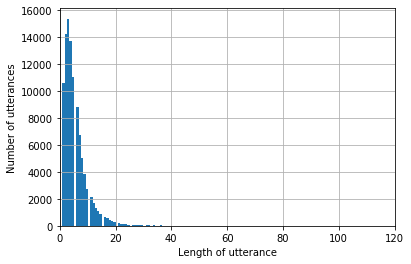

In [35]:
# examining the distribution of the description lengths
df.utter_len.hist(bins = 140)
plt.xlim([0, 120])
plt.xlabel('Length of utterance')
plt.ylabel('Number of utterances')

## Identify The Most Frequent Words

There are a lot of stop words in the list of most frequent words in thedescriptions.  We will need to remove the stop words to get closer to isolating the most relevant keywords in the descriptions.

In [36]:
# getting the word frequency of the original utterance
word_freq = df.dialogue.str.split(expand=True).stack().value_counts()

In [37]:
word_freq[:20]

.       116118
,        54565
I        43988
you      40432
?        39102
the      35226
to       32464
a        26870
and      14981
it       14634
is       14527
’        13980
of       13104
in       12447
for      12263
have     11900
that     10458
!         9325
your      8886
are       8672
dtype: int64

<BarContainer object of 20 artists>

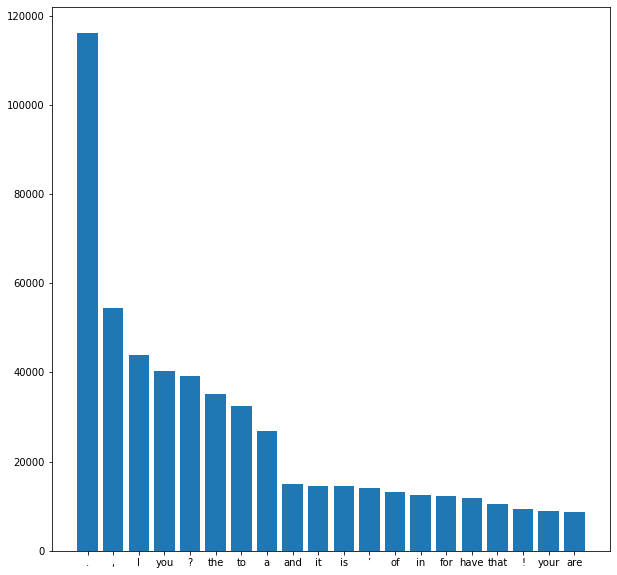

In [38]:
word_freq_top_20 = word_freq[:20]
word_freq_top_20 = dict(word_freq_top_20)
plt.figure(figsize=(10,10))
plt.bar(range(len(word_freq_top_20)), word_freq_top_20.values(), tick_label=list(word_freq_top_20.keys()))

In [40]:
# getting the word frequency of the original utterance
word_freq_clean = df.utter_clean.str.split(expand=True).stack().value_counts()

In [41]:
word_freq_clean[:20]

like      7121
yes       6238
well      5157
im        4775
think     4672
good      4550
know      4349
get       4265
would     4196
go        3949
one       3700
dont      3675
see       3674
right     3620
really    3516
want      3302
please    3266
time      3248
oh        3065
thats     2953
dtype: int64

## Remove Stop Words and Compare Descriptions

After removing stop words, the descriptions are closer to containing only the key words that are most relevant for each movie.

In [376]:
# first of all, let us remove some useless words to see how our documents change
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english')) 

In [377]:
df['desc_cleaned'] = df.desc.apply(lambda x:x.lower())
df['without_stopwords'] = df['desc_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df.head()

,movieId,imdbId,tmdbId,desc,desc_leng,desc_cleaned,without_stopwords
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ...",50,"led by woody, andy's toys live happily in his ...","led woody, andy's toys live happily room andy'..."
1,2,113497,8844,When siblings Judy and Peter discover an encha...,67,when siblings judy and peter discover an encha...,siblings judy peter discover enchanted board g...
2,3,113228,15602,A family wedding reignites the ancient feud be...,56,a family wedding reignites the ancient feud be...,family wedding reignites ancient feud next-doo...
3,4,114885,31357,"Cheated on, mistreated and stepped on, the wom...",45,"cheated on, mistreated and stepped on, the wom...","cheated on, mistreated stepped on, women holdi..."
4,5,113041,11862,Just when George Banks has recovered from his ...,59,just when george banks has recovered from his ...,"george banks recovered daughter's wedding, rec..."


In [378]:
# comparing description with stopwords and description without stopwords
print(df.without_stopwords[0])
print('------------------------')
print(df.desc[0])

led woody, andy's toys live happily room andy's birthday brings buzz lightyear onto scene. afraid losing place andy's heart, woody plots buzz. circumstances separate buzz woody owner, duo eventually learns put aside differences.
------------------------
Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


# Extract Genre Names and Include in the Description

After testing the model based on the cleaned descriptions, we decided to improve the model's performance by extracting the genres from each movie and including those genre names in the movie description.  This did improve the results slightly.

In [380]:
df = pd.merge(df, lens_deets, on='movieId')

In [381]:
df.head()

,movieId,imdbId,tmdbId,desc,desc_leng,desc_cleaned,without_stopwords,title,genres
0,1,114709,862,"Led by Woody, Andy's toys live happily in his ...",50,led woody andys toys live happily room andys b...,"led woody, andy's toys live happily room andy'...",Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,113497,8844,When siblings Judy and Peter discover an encha...,67,siblings judy peter discover enchanted board g...,siblings judy peter discover enchanted board g...,Jumanji (1995),Adventure|Children|Fantasy
2,3,113228,15602,A family wedding reignites the ancient feud be...,56,family wedding reignites ancient feud nextdoor...,family wedding reignites ancient feud next-doo...,Grumpier Old Men (1995),Comedy|Romance
3,4,114885,31357,"Cheated on, mistreated and stepped on, the wom...",45,cheated mistreated stepped women holding breat...,"cheated on, mistreated stepped on, women holdi...",Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,113041,11862,Just when George Banks has recovered from his ...,59,george banks recovered daughters wedding recei...,"george banks recovered daughter's wedding, rec...",Father of the Bride Part II (1995),Comedy


In [382]:
df['genres'] = df['genres'].apply(clean_text)

In [383]:
df['desc_cleaned'] = df['desc_cleaned'] + " | " + df['genres']

In [384]:
# compare the cleaned version of description
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences | adventure animation children comedy fantasy'

In [385]:
df['desc_cleaned'] = df['desc_cleaned'].apply(clean_text)

In [386]:
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences adventure animation children comedy fantasy'

<BarContainer object of 20 artists>

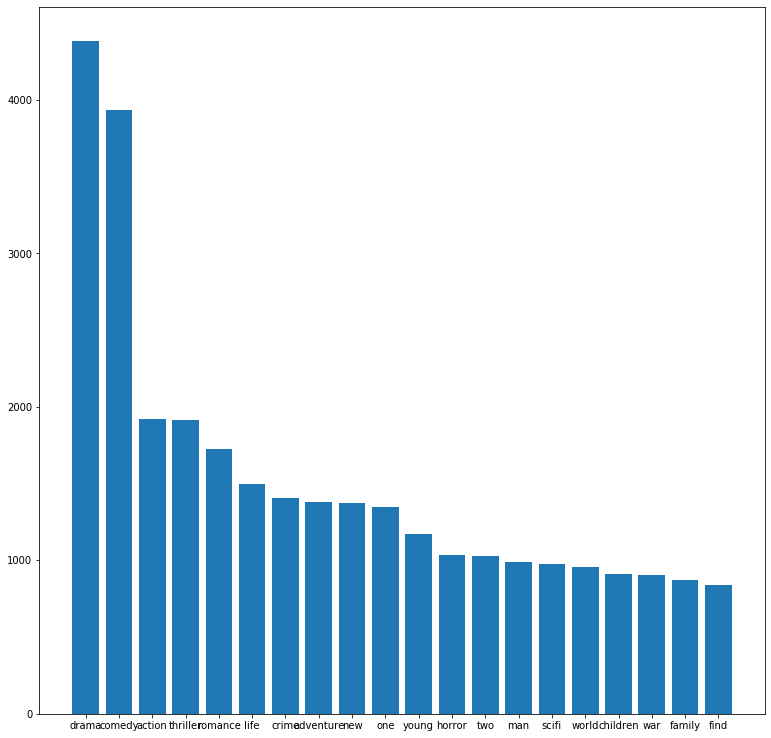

In [387]:
word_freq_clean = df.desc_cleaned.str.split(expand=True).stack().value_counts()
word_freq_clean[:20]
plt.figure(figsize=(13,13))
plt.bar(range(len(word_freq_clean[:20])), dict(word_freq_clean[:20]).values(), tick_label=list(dict(word_freq_clean[:20]).keys()))

# <span id="3"></span>3. Building Recommendation Engine
#### [Return Contents](#0)

In [388]:
df.set_index('title', inplace = True)

In [400]:
df['desc_cleaned'][0]

'led woody andys toys live happily room andys birthday brings buzz lightyear onto scene afraid losing place andys heart woody plots buzz circumstances separate buzz woody owner duo eventually learns put aside differences adventure animation children comedy fantasy'

We calculated the cosine similarity between descriptions by using the TF-IDF Vectorizer.

In [389]:
# calculate cosine similarity between documents - we use tfidf
from sklearn.metrics.pairwise import cosine_similarity
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['desc_cleaned'])
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(cosine_similarity(tfidf_matrix, tfidf_matrix))

[[1.00000000e+00 8.39456921e-03 4.75486529e-04 ... 3.98869606e-03
  0.00000000e+00 6.80819529e-03]
 [8.39456921e-03 1.00000000e+00 5.52109710e-03 ... 4.94571179e-03
  0.00000000e+00 1.53948610e-03]
 [4.75486529e-04 5.52109710e-03 1.00000000e+00 ... 2.91077410e-03
  3.34296242e-03 0.00000000e+00]
 ...
 [3.98869606e-03 4.94571179e-03 2.91077410e-03 ... 1.00000000e+00
  0.00000000e+00 5.62537299e-03]
 [0.00000000e+00 0.00000000e+00 3.34296242e-03 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [6.80819529e-03 1.53948610e-03 0.00000000e+00 ... 5.62537299e-03
  0.00000000e+00 1.00000000e+00]]


We saved the cosine similarity matrix for use in other hybrid systems.

In [401]:
import pickle
filename = 'cosine_sim_matrix.pickle'
pickle.dump(similarity_matrix, open(filename, 'wb'))

In [390]:
indices = pd.Series(df.index)

In [391]:
def recommendations(name, similarity_matrix = similarity_matrix):
    
    recommended_movies = []
    
    # getting the index of the movie that matches the name
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(similarity_matrix[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies except itself
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    #Cross reference top n indexes with sleeping giants (and/or giants)
    
    # populating the list with the names of the top 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(df.index)[i])
        
    return recommended_movies

In [392]:
# get the list of optional names 
df.index

Index(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
       'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)',
       'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)',
       'Sudden Death (1995)', 'GoldenEye (1995)',
       ...
       'Gintama (2017)', 'Gintama: The Movie (2010)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'Silver Spoon (2014)', 'Love Live! The School Idol Movie (2015)',
       'Jon Stewart Has Left the Building (2015)',
       'Black Butler: Book of the Atlantic (2017)',
       'No Game No Life: Zero (2017)', 'Flint (2017)',
       'Bungo Stray Dogs: Dead Apple (2018)'],
      dtype='object', name='title', length=9584)

## Model Testing

Input your favorite movie from the list of almost 10,000 films and get a list of the 10 most similar movies based on their descriptions.

In [397]:
recomendations = input("what types of movies would you like me to recommend for ya?")
recommendations(recomendations)

what types of movies would you like me to recommend for ya?Toy Story (1995)


['Toy Story 2 (1999)',
 'Toy Story 3 (2010)',
 "Child's Play 2 (1990)",
 'Wild, The (2006)',
 'Turbo (2013)',
 'Monsters, Inc. (2001)',
 'The Good Dinosaur (2015)',
 'Malice (1993)',
 'Rebel Without a Cause (1955)',
 'Condorman (1981)']

We can improve this system by including conditional statements in the recommendation function to filter out inapproproate or unrelated recommendations based on their genre, release year, and suitability rating.